In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-white')

# Predikce za tempocí HONU (1.,2. a 3. řádu)

In [175]:
import numpy as np

class HONU_accessory():
    """
    contains additional method used in HONU class to calculate the length of colx and colx by the given order
    """
# -----------  
    def get_length(self, sliding_window, order):
        """used for initialization for class HONU to create weight row of expected length"""
        temp = sliding_window
        if order==1:  # LNU
            n=temp
        elif order==2:  # QNU
            n=(temp**2+temp)/2
        elif order==3:  # CNU
            n=0
            for i in range(temp):
                for j in range(i,temp):
                    for l in range(j,temp):
                        n += 1
        return int(n)
# -----------    
    def make_colx(self, x, order):
        """used to create colx from inputs every call of forward method in HONU"""
        nx = self.nx  # number of real inputs
        n = self.n  # number of variable is colX
        colx=np.ones(n)
        temp=0
        
        # needs remake
        xx = np.ones(nx)
        xx[1:] = x
        x=xx
        
        if order==1: # LNU
            colx=x

        if order==2:  # QNU
            for i in range(nx):
                for j in range(i,nx):
                    colx[temp]=x[i]*x[j]
                    temp+=1

        if order==3:  # CNU
            for i in range(nx):
                for j in range(i,nx):
                    for l in range(j,nx):
                        colx[temp]=x[i]*x[j]*x[l]
                        temp+=1                   
        return np.array(colx)

class HONU(HONU_accessory):
    """ function is able to create 1-3 order of neural network """
    def __init__(self, size_sliding_window,  order, n_outputs=0, n_inputs=1):
        self.nx = size_sliding_window*(n_outputs+n_inputs) +1 # add one for bias of the unit [1, y_recent ... y_past, u_recent...u_past]
        self.order = order
        self.n = self.get_length(self.nx, order = self.order)
        self.w = np.random.uniform(-1,1, size=(1,self.n))
    
    def info(self):
        """ prints out info about network """
        print("Order of Honu: ", self.order)
        print("Number of inputs in sliding window (with bias): ", self.nx)
        print("Length of HONU vector: ", self.n)
        print("Weights: ", "\n",self.w)
        print("Example of colx for x=list(range(1,sliding_window))","\n", self.make_colx(list(range(1,self.nx)), order=2))
        
    def forward(self, x):
        """calculate output of the unit"""
        self.colx = self.make_colx(x, self.order)
        y_pred = np.dot(self.colx, self.w.T)
        return y_pred
    
    def loss(self, y_true, y_pred):
        """simple loss"""
        e = y_true - y_pred
        return e
    
    def backward(self, e, lr=1.0):
        """GD calculation with applied norm"""
        mu = lr/(1+np.dot(self.colx,self.colx)) # learning rate divided by squared euclidean norm
        dw = mu*e*self.colx
        return dw
    
    def optimizer(self, dw):
        """method to calculated new weights"""
        self.w = self.w+dw
        return self.w        

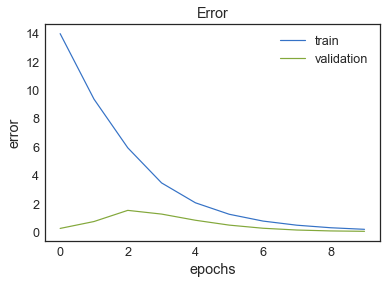

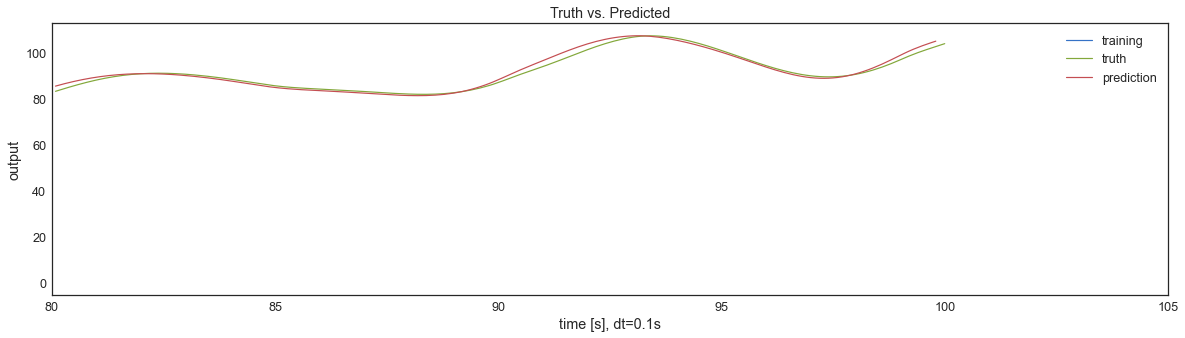

Min and Max value of weight:  50.39891283912194 -0.7036964419532619


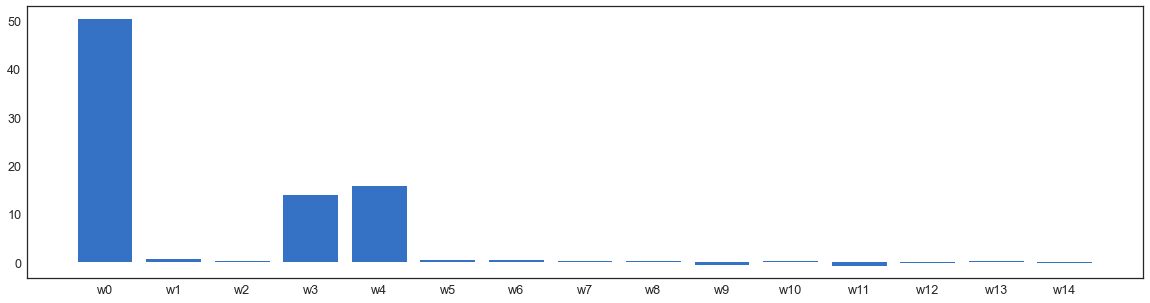

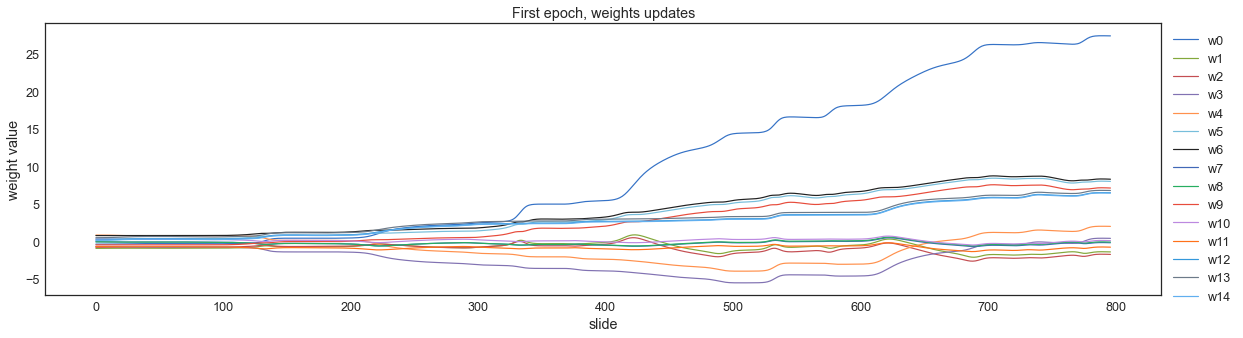

In [179]:
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
SLIDING_WINDOW = 2
EPOCHS = 10

# initializing class
qnu = HONU(SLIDING_WINDOW, n_outputs=1, order=2)

# importing data
Xy = pd.read_csv("Xy_11.csv")
Xy[["vstup","výstup_scale"]] = scale(Xy[["vstup","výstup"]])

train, test = train_test_split(Xy, shuffle=False, test_size=0.2)


# scalling train data
X = train["vstup"]
y_scaled = train["výstup_scale"].to_numpy()
y = train["výstup"].to_numpy()
time = train["time"].to_numpy()

# scalling test data
y_pred = []
Xval = test["vstup"]
y_scaledval = test["výstup_scale"].to_numpy()
yval = test["výstup"].to_numpy()
time_val = test["time"].to_numpy()

# prints info about class QNU
#qnu.info()

# control variables plotted afterwards
error = []
val_error = []
weight_change = []
temp = 1
weights = {}
for i,w in enumerate(qnu.w[0]):
    weights["w"+str(i)] = [w]


# training------------
for _ in range(EPOCHS):
    epoch_error= []
    val_epoch_error= []
    for part in range(len(X)-SLIDING_WINDOW-1):
        
        x = X[part:SLIDING_WINDOW+part]
        x = np.append(x, y_scaled[part:SLIDING_WINDOW+part])
        y_true = y[SLIDING_WINDOW+part+1]
        
        y_pred = qnu.forward(x)
        e = qnu.loss(y_true,y_pred)
        epoch_error.append(e)
        dw = qnu.backward(e, lr=0.01)
        w = qnu.optimizer(dw)
        if temp ==1:
            weight_change.append(w.T)
           
    temp=0 
        
# epoch validation------------
    for part in range(len(Xval)-SLIDING_WINDOW-1):
        
        x = Xval[part:SLIDING_WINDOW+part]
        x = np.append(x, y_scaledval[part:SLIDING_WINDOW+part])
        y_true = yval[SLIDING_WINDOW+part+1]
        
        y_pred = qnu.forward(x)
        e = qnu.loss(y_true,y_pred)
        val_epoch_error.append(e)
        
        
    error.append(np.mean(epoch_error))
    val_error.append(np.mean(val_epoch_error))

    
# Plotting Train/Test error

plt.figure()
plt.plot(range(EPOCHS),np.abs(error))
plt.plot(range(EPOCHS),np.abs(val_error))
plt.title("Error")
plt.xlabel("epochs")
plt.ylabel("error")
plt.legend(("train", "validation"))
plt.show()


# Final validation--------------
y_pred = []
for part in range(len(Xval)-SLIDING_WINDOW):
    x = Xval[part:SLIDING_WINDOW+part]
    x = np.append(x, y_scaledval[part:SLIDING_WINDOW+part])
    y_pred.append(qnu.forward(x))
    
    
# Plotting train, validation on truth data
# def plot_validation(y, y_val, y_pred)    
plt.figure(figsize=(20,5))
plt.plot(time, y)
plt.plot(time_val,yval)
plt.plot(time_val[:len(y_pred)],y_pred)
plt.title("Truth vs. Predicted")
plt.xlabel("time [s], dt=0.1s")
plt.ylabel("output")
plt.legend(("training","truth","prediction"))
plt.axis(xmin=80)
plt.show()

# Visualizing value of weights
print("Min and Max value of weight: ",np.max(w), np.min(w))
plt.figure(figsize=(20,5))
labels = ["w"+str(i) for i in range(len(w[0]))]
plt.bar(x=labels,height=w[0])
plt.show()

# change of weights in first epoch
for slide in weight_change[1:]:
    for i, w in enumerate(slide):
        if "w"+str(i) in weights.keys():
            weights["w"+str(i)].append(w[0])
        else:
            weights["w"+str(i)] = [w[0]]
            
df_w = pd.DataFrame(weights)
            
df_w.plot(figsize=(20,5))
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title("First epoch, weights updates")
plt.xlabel("slide")
plt.ylabel("weight value")
plt.show()